# Swiss Mortality

Data Sources:
- [Human Mortality Database](https://www.mortality.org/)</br>
  [Short-term Mortality Fluctuations Dashboard](https://mpidr.shinyapps.io/stmortality/)</br>
  Data: https://www.mortality.org/Public/STMF/Outputs/stmf.csv
- [Todesfälle nach Monat und Sterblichkeit seit 1803](https://www.bfs.admin.ch/asset/de/px-x-0102020206_111)</br>
  BFS-Nummer px-x-0102020206_111
- [Ständige Wohnbevölkerung nach Geschlecht und Alter, 1860-2019](https://www.bfs.admin.ch/asset/de/px-x-0102030000_101)</br>
  BFS-Nummer 	px-x-0102030000_101

## 1. Human Mortality Database

In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import altair as alt


# As our dataset will contain more than 5000 rows.
alt.data_transformers.disable_max_rows()

df_mortality = pd.read_csv(
    "https://www.mortality.org/Public/STMF/Outputs/stmf.csv",
    skiprows=2,
)

In [3]:
# Select countries of interest
# Note: Germany "DEUTNP" and "USA" have short time series
df_mortality = df_mortality[
    df_mortality["CountryCode"].isin(["CAN", "CHE", "FRATNP", "GBRTENW", "SWE"])
].copy()

# Change to ISO-3166-1 ALPHA-3 codes
df_mortality["CountryCode"].replace(
    {"FRATNP": "FRA", "GBRTENW": "England & Wales"}, inplace=True
)

# create date column and set it as index
df_mortality["Date"] = pd.to_datetime(
    df_mortality["Year"].astype(str) + df_mortality["Week"].astype(str) + "0",
    format="%Y%W%w",
)
df_mortality.set_index("Date", inplace=True)

# create population (exposure) to ease aggregation
df_mortality = df_mortality.assign(population=lambda df: df["DTotal"] / df["RTotal"])

In [4]:
chart = (
    alt.Chart(df_mortality.reset_index().query("CountryCode == 'CHE'"))
    .mark_line()
    .encode(
        x="Date:T",
        y=alt.Y("RTotal:Q", scale=alt.Scale(zero=False)),
        color="Sex:N",
    )
    .properties(title="Swiss Mortality Rate per Month")
    .interactive()
)
chart

alt.Chart(...)

In [5]:
chart = (
    alt.Chart(df_mortality.reset_index())
    .transform_aggregate(
        sum_popul="sum(population)",
        sum_death="sum(DTotal)",
        groupby=["Year", "Sex", "CountryCode"],
    )
    .transform_calculate(
        CDR="datum.sum_death / datum.sum_popul", Time="datetime(datum.Year, 0)"
    )
    .mark_line()
    .encode(
        x="Time:T",
        y=alt.Y("CDR:Q", scale=alt.Scale(zero=False)),
        strokeDash="Sex:N",
        color="CountryCode:N",
    )
    .properties(title="Crude Death Rate per Year")
    .interactive()
)
# chart.save("swiss_mortality_chart.html")
chart

alt.Chart(...)

In [6]:
# now the same but with small date to reduce the size of html
df = (
    df_mortality.groupby(["Year", "Sex", "CountryCode"])[["population", "DTotal"]]
    .sum()
    .assign(CDR=lambda x: x["DTotal"] / x["population"])
    .filter(items=["RTotal"])
    .reset_index()
    .assign(Year=lambda x: pd.to_datetime(x["Year"], format="%Y"))
)
chart = (
    alt.Chart(df)
    .mark_line()
    .encode(
        x="Year:T",
        y=alt.Y("CDR:Q", scale=alt.Scale(zero=False)),
        strokeDash="Sex:N",
        color="CountryCode:N",
    )
    .properties(title="Crude Death Rate per Year")
    .interactive()
)
# chart.save("swiss_mortality_chart.html")
chart

alt.Chart(...)

## 2. Federal Statistical Office of Switzerland

In [7]:
from contextlib import contextmanager
import locale

from pyaxis import pyaxis


@contextmanager
def localized(code):
    old_code, old_encoding = locale.getlocale()
    if old_code is None:
        old_code = "de_DE"
    locale.setlocale(locale.LC_ALL, code)
    yield
    # locale.setlocale(locale.LC_ALL, f"{old_code}.{old_encoding}")

In [8]:
# px-x-0102020206_111
px = pyaxis.parse(
    "https://www.bfs.admin.ch/bfsstatic/dam/assets/14387168/master",
    encoding="ISO-8859-2",
)
# px["METADATA"]
df_death = px["DATA"]

# px-x-0102030000_101
px = pyaxis.parse(
    "https://www.bfs.admin.ch/bfsstatic/dam/assets/14819631/master",
    encoding="ISO-8859-2",
)
df_popul = px["DATA"]

In [9]:
df_mortality = df_mortality.query("CountryCode == 'CHE'").copy()

In [10]:
df_death["Demografisches Merkmal und Indikator"].value_counts().sort_index()

Geschlechterverhältnis beim Tod                  217
Lebenserwartung bei der Geburt - Frau            217
Lebenserwartung bei der Geburt - Mann            217
Lebenserwartung im Alter von 65 Jahren - Frau    217
Lebenserwartung im Alter von 65 Jahren - Mann    217
Säuglingssterbeziffer (in Promille)              217
Säuglingssterbeziffer (in Promille) - Knabe      217
Säuglingssterbeziffer (in Promille) - Mädchen    217
Todesfälle - Total                               217
Todesfälle im April                              217
Todesfälle im August                             217
Todesfälle im Dezember                           217
Todesfälle im Februar                            217
Todesfälle im Januar                             217
Todesfälle im Juli                               217
Todesfälle im Juni                               217
Todesfälle im Mai                                217
Todesfälle im März                               217
Todesfälle im November                        

In [11]:
df_popul["Geschlecht"].value_counts()

Mann                  16160
Geschlecht - Total    16160
Frau                  16160
Name: Geschlecht, dtype: int64

In [12]:
df_popul["Alter"].value_counts().sort_index()

0 Jahre              480
1 Jahr               480
10 Jahre             480
11 Jahre             480
12 Jahre             480
                    ... 
96 Jahre             480
97 Jahre             480
98 Jahre             480
99 Jahre und mehr    480
Alter - Total        480
Name: Alter, Length: 101, dtype: int64

In [13]:
# Preprocess deaths data
df_death = df_death[
    df_death["Demografisches Merkmal und Indikator"].str.contains("Todesfälle im")
]
df_death["Jahr"] = pd.to_numeric(df_death["Jahr"], errors="coerce")
df_death["Monat"] = df_death["Demografisches Merkmal und Indikator"].str.split().str[-1]
df_death["deaths"] = pd.to_numeric(df_death["DATA"], errors="coerce")
df_death = df_death[df_death["Jahr"] >= 1900]

with localized("de_DE.UTF-8"):
    df_death["date"] = pd.to_datetime(
        df_death["Monat"] + " " + df_death["Jahr"].astype(str), format="%B %Y"
    )

df_death.drop(columns=["Demografisches Merkmal und Indikator", "DATA"], inplace=True)

df_death.set_index("date", inplace=True)


# Preprocess population data
df_popul = df_popul[
    (df_popul["Geschlecht"] == "Geschlecht - Total")
    & (df_popul["Alter"] == "Alter - Total")
].copy()
df_popul["Jahr"] = pd.to_numeric(df_popul["Jahr"], errors="coerce")
df_popul = df_popul[df_popul["Jahr"] >= 1900]
df_popul["population"] = pd.to_numeric(df_popul["DATA"], errors="coerce").astype(float)
df_popul.drop(columns=["DATA"], inplace=True)
df_popul.set_index("Jahr", inplace=True)

<AxesSubplot:xlabel='date'>

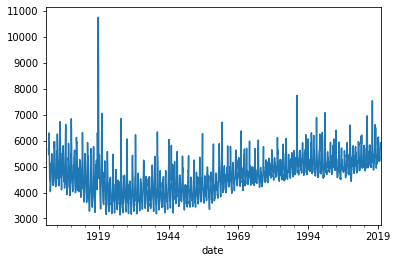

In [14]:
df_death["deaths"].plot()

<AxesSubplot:xlabel='Jahr'>

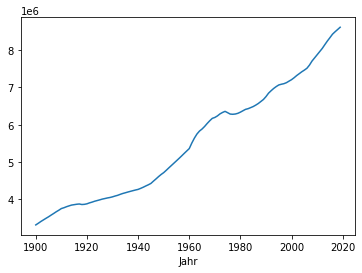

In [15]:
df_popul["population"].plot()

Text(0, 0.5, 'CDR')

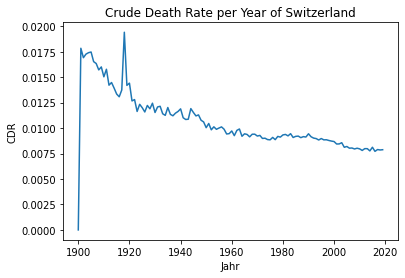

In [16]:
df = pd.merge(
    df_death.groupby("Jahr").sum(),
    df_popul,
    how="inner",
    on="Jahr",
)
df["mortality_rate"] = df["deaths"] / df["population"]
ax = df["mortality_rate"].plot(title="Crude Death Rate per Year of Switzerland")
ax.set_ylabel("CDR")